# Load libraries and data

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(dada2)
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(reshape2)
library(genefilter)
library(microbiome)
library(VennDiagram)
#library(svglite)
#library(gridExtra)
library(DESeq2); packageVersion("DESeq2")

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.28.0’

Loading required package: Rcpp


[1] ‘3.2.1’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


[1] ‘2.5.6’


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2019 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>


Attaching package: ‘microbiome’

The following object is masked from ‘package:scales’:

    alpha

The following object is masked from ‘package:vegan’:

    diversity

The following object is masked from ‘package:ggplot2’:

    alpha

The following object is masked from ‘package:base’:

    transform

Loading required package: grid
Loading required package: futile.logger
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRap

[1] ‘1.24.0’

In [2]:
ps <- readRDS("~/data/awtp2_16S/ps_clean_filt.rds")

In [3]:
# Add metadata
metadata_complete <- read.table('~/data/awtp2_16S/metadata_final.tsv', sep="\t", header=TRUE, row.names=1)
metadata_complete$location_code<- gsub("WW_tertiary", "WW_3ary", metadata_complete$location_code)

#reset order of levels
location_levels = c(
    'field_blank',
    'RO_BF_control',
    'negative_control',
    'WW_3ary',
    'BAC',
    'MF_combined',
    'MF_tank',
    'RO_BF_retentate_scrapings',
    'RO_BF_separator',
    'RO_combined',
    'RO_3stage', 'RO_2stage', 'RO',
    'Loop_DPWF_inf', 'Loop_MWTP_inf', 'Loop_1', 'Loop_2', 'Loop_3', 'Loop_4', 'Loop_5',
    'DWDS_328', 'DWDS_286', 'DWDS_282B')
metadata_complete$location_code <- factor(metadata_complete$location_code, levels=location_levels)

head(metadata_complete)

,id_full,count_raw_reads,barcode_forward,barcode_reverse,plate,well,metagenomic_sample,sample_code_full_and_batch,sample_date,batch_sample_date,⋯,broad_location,HPC_avg_MPN_per_100mL,experimental_detail,percent_CRA,SG,SGPI,intra_ATP_avg_nM,total_ATP_avg_nM,extra_ATP_avg_nM,SampleID
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
SD003,KNLK_SD003,52728,CGTTACTA,CTCTAGAG,1,B3,Y,DWDS_F_utility_bulk_9_A_12,2018-03-28,NA,⋯,DWDS_F,26,NA,0.4626015,26076.8,471.2,NA,NA,NA,KNLK_SD003
SD004,KNLK_SD004,35359,AGAGTCAC,CTCTAGAG,1,C3,Y,SDS_F_5_biofilm_9_NA_8,2018-04-09,2018-04-09,⋯,Pipe_Loop,NA,NA,NA,5999.9,1786.3,7.156732e-05,0.001976834,0.0018942843,KNLK_SD004
SD005,KNLK_SD005,35380,TACGAGAC,CTCTAGAG,1,D3,Y,DWDS_F_328_bulk_5_A_13,2018-04-19,NA,⋯,DWDS_F,17,NA,0.6899480,1946.3,768.3,1.629695e-01,0.163264704,0.0002094437,KNLK_SD005
SD006,KNLK_SD006,30734,TACGAGAC,CATGAGGA,1,D5,Y,AWTP_2_RO2_biofilm_sep_1_A_RO1_A57,2018-01-10,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,KNLK_SD006
SD007,KNLK_SD007,35135,CTACTATA,AGTCTAGA,1,A6,Y,AWTP_3_MF_tank_bulk_1_A_18,2018-03-13,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,KNLK_SD007
SD008,KNLK_SD008,16805,CGTTACTA,AGTCTAGA,1,B6,Y,DWDS_F_328_bulk_1_A_12,2018-02-14,NA,⋯,DWDS_F,6,NA,0.2500000,12870.7,4390.4,5.347541e-04,0.001805507,0.0012105474,KNLK_SD008


In [4]:
sample_data(ps) <- metadata_complete

In [5]:
#change ASV names to short codes, store DNA seqs in ref_seq object in phyloseq
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 149 samples ]
sample_data() Sample Data:       [ 149 samples by 43 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 6825 reference sequences ]

In [6]:
#saveRDS(ps, '~/data/awtp2_16S/ps_clean_filt_metadata.rds')

# Alpha diversity

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”

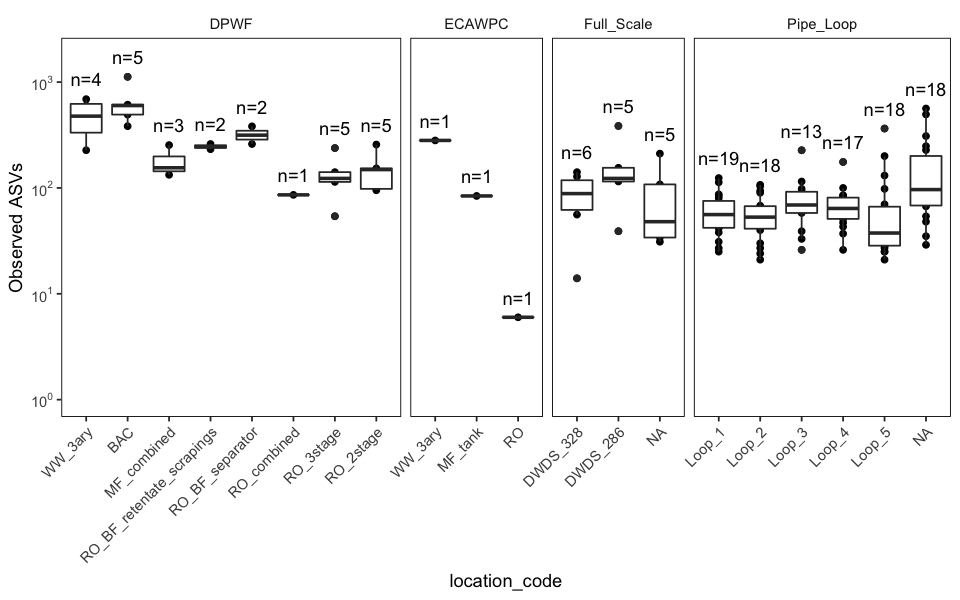

In [7]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
#ps_bulk_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Bulk")
options(repr.plot.width = 8, repr.plot.height = 5)
plot_richness(ps, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     #strip.text.x = element_blank(),
     #axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(1,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    facet_grid(.~project_type, scale="free_x", space="free_x")

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/asv_observed_boxplot.svg", device="svg", width=3.5, height=2.75)

In [8]:
# select only samples of interest
ps_dpwf <- subset_samples(ps, subset = project_type %in% c("DPWF", "ECAWPC"))
ps_dpwf <- filter_taxa(ps_dpwf, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads

In [9]:
sample_data(ps_dpwf)$location_gen <- sample_data(ps_dpwf)$location_code
                                            
new_levels <- c('WW_3ary',
'BAC',
'MF_combined',
'MF_tank',
'MF',
'RO_BF_retentate_scrapings',
'RO_BF_separator',
'RO_combined',
'RO_3stage',
'RO_2stage',
'RO')

sample_data(ps_dpwf)$location_gen <- factor(sample_data(ps_dpwf)$location_gen, levels=new_levels)

In [10]:
# change factor levels to condense down to simple location
sample_data(ps_dpwf)[sample_data(ps_dpwf)$location_code %in% c("MF_tank", "MF_combined"),]$location_gen <- "MF"
sample_data(ps_dpwf)[sample_data(ps_dpwf)$location_code %in% c("RO", "RO_combined", "RO_3stage", "RO_2stage"),]$location_gen <- "RO"

In [11]:
#saveRDS(ps_dpwf, '~/data/awtp2_16S/ps_awtp2.rds')

In [12]:
# normalize to percents
ps_dpwf_perc <- transform_sample_counts(ps_dpwf, function(x) 100*x/sum(x))

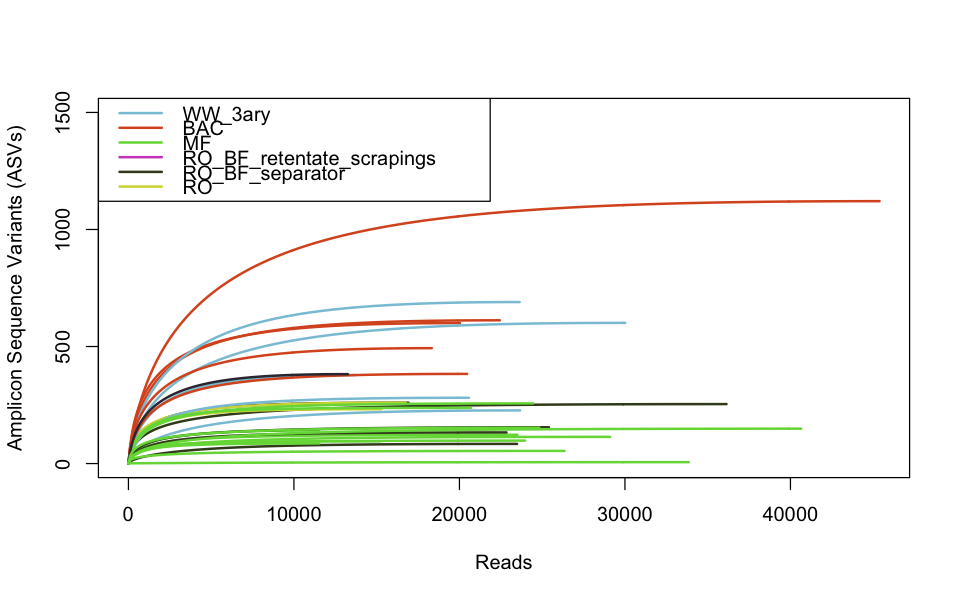

In [13]:
otu_tab <- as.data.frame(otu_table(ps_dpwf))

locations_colors <- c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12])
palette(c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))

options(repr.plot.width = 8, repr.plot.height = 5)

#pdf("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/rarecurve_bulk_nolabels.pdf", height=6, width=8)
rarecurve(otu_tab, step=100, col=sample_data(ps_dpwf)$location_gen, 
          xlab="Reads", ylab="Amplicon Sequence Variants (ASVs)", lwd=2, ylim=c(0,1500), label=FALSE)

legend("topleft", legend=c('WW_3ary',
                           'BAC',
                           'MF',
                           'RO_BF_retentate_scrapings',
                           'RO_BF_separator',
                           'RO'), 
       col=locations_colors, 
       lty=1, lwd=2)


Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”

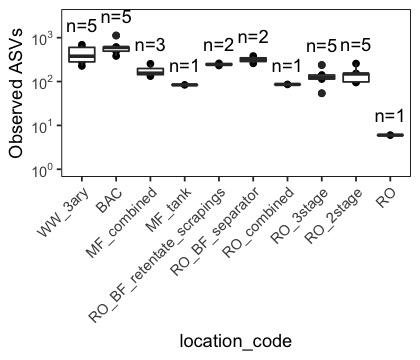

In [14]:
#define function to put sample count above data
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 3.5, repr.plot.height = 3)
plot_richness(ps_dpwf, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     strip.text.x = element_blank(),
     #axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(1,3000), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)
    #geom_vline(xintercept=5.5, linetype='solid')

# Taxonomic composition

In [15]:
ps_dpwf_perc_filt1.3 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 3)), TRUE)
ps_dpwf_perc_filt1.3
ps_dpwf_perc_filt2.1 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(2, 1)), TRUE)
ps_dpwf_perc_filt2.1
ps_dpwf_perc_filt1.1 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 1)), TRUE)
ps_dpwf_perc_filt1.1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 78 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 78 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 78 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 78 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 78 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 78 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 210 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 210 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 210 reference sequences ]

Warning message:
“Transformation introduced infinite values in discrete y-axis”

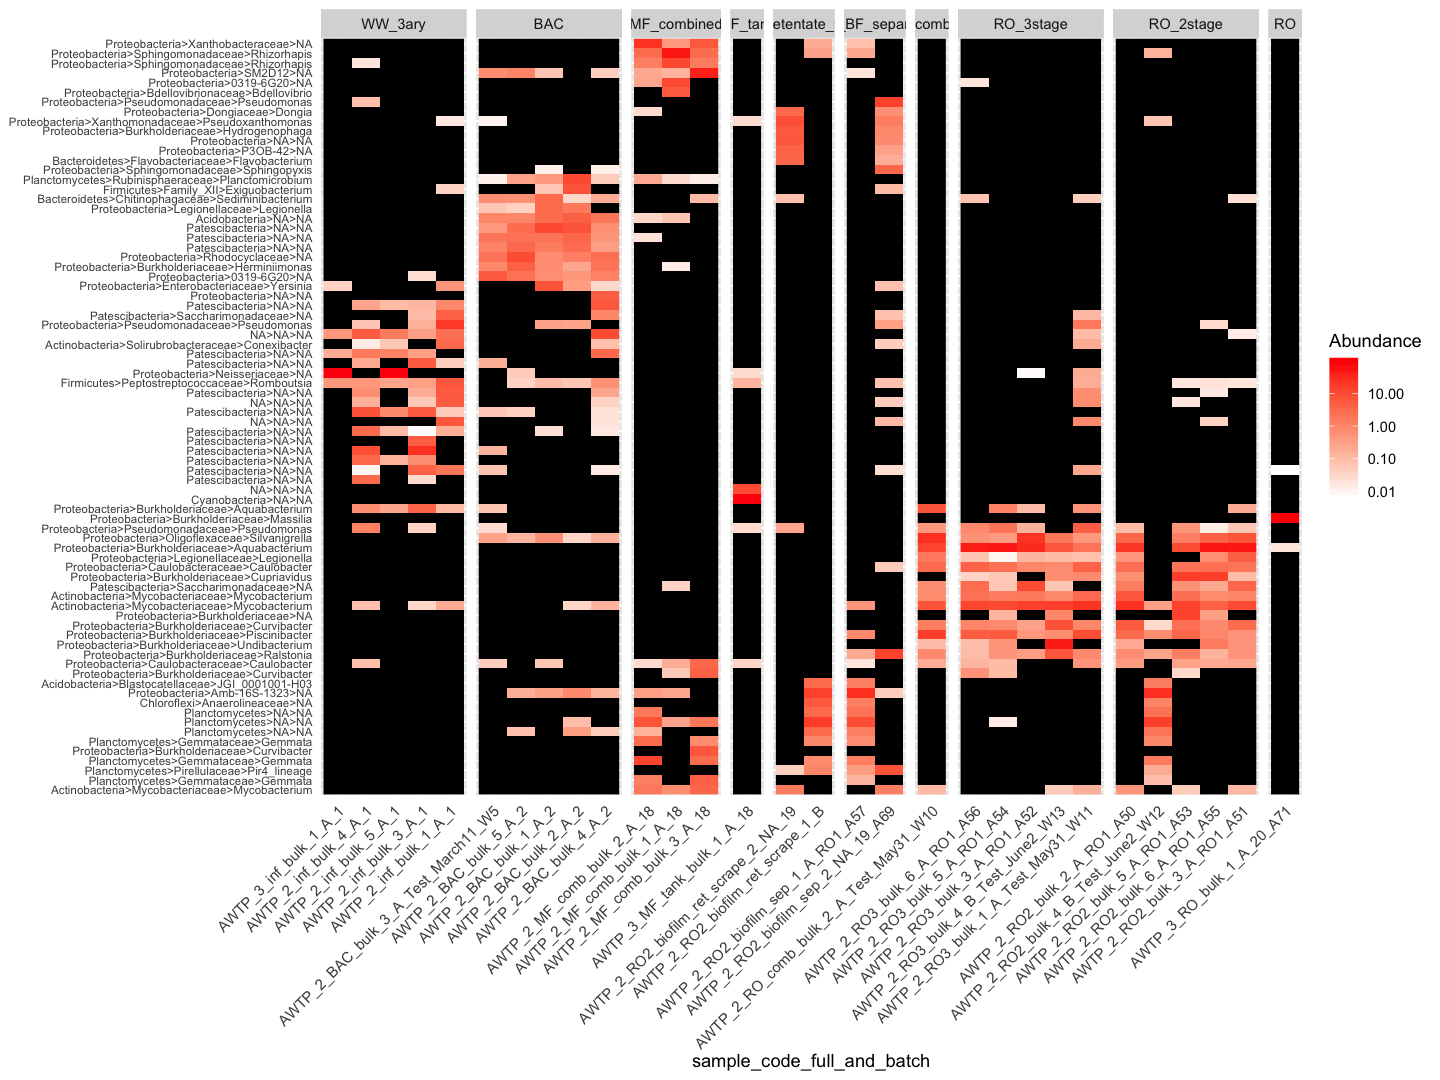

In [16]:
#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 9)
plot_heatmap(ps_dpwf_perc_filt1.3, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")

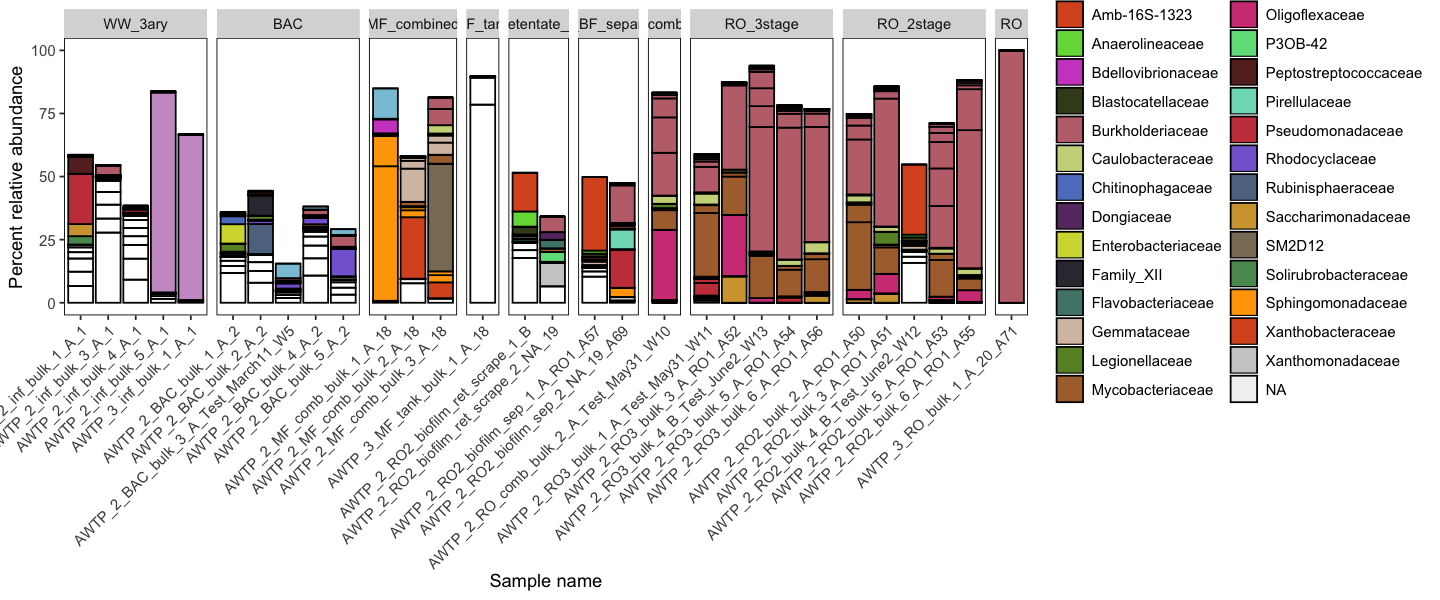

In [17]:
## Family, by ASV segment for abundant ASVs (>3% in 1 sample)
options(repr.plot.width = 12, repr.plot.height = 5)

plot_bar(ps_dpwf_perc_filt1.3, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

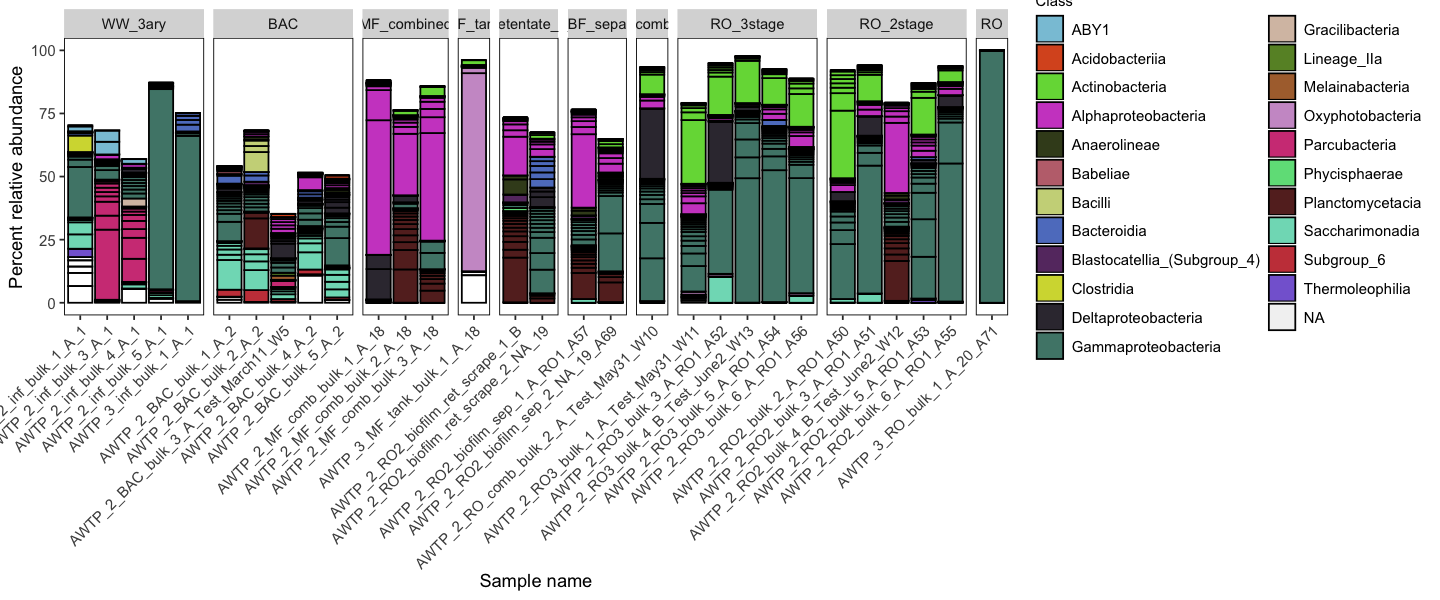

In [18]:
## Phyla, by ASV segment for abundant ASVs (>1% in 1 sample)
options(repr.plot.width = 12, repr.plot.height = 5)

plot_bar(ps_dpwf_perc_filt1.1, x="sample_code_full_and_batch", fill="Class") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 16 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 16 reference sequences ]

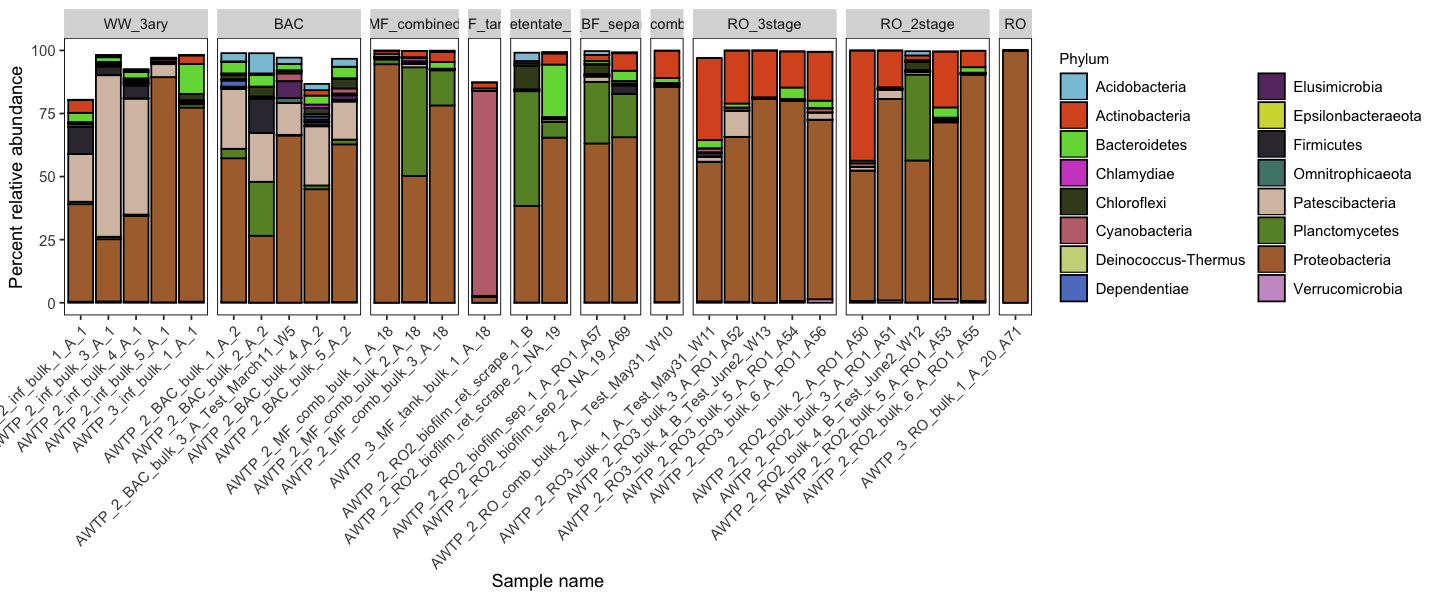

In [19]:
## Phyla agglomerated barplot

ps_dpwf_perc_phylum <- tax_glom(ps_dpwf_perc, "Phylum")
ps_dpwf_perc_phylum_filt1.05 <- filter_taxa(ps_dpwf_perc_phylum, filterfun(kOverA(1, 0.5)), TRUE)
ps_dpwf_perc_phylum_filt1.05

## Plot bar and heatmap
options(repr.plot.width = 12, repr.plot.height = 5)

plot_bar(ps_dpwf_perc_phylum_filt1.05, x="sample_code_full_and_batch", fill="Phylum") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

In [20]:
# plotting just single locations to see more depth
ps_ww3ary <- subset_samples(ps_dpwf_perc, subset = location_code %in% "WW_3ary")
ps_ww3ary_filt1.1 <- filter_taxa(ps_ww3ary, filterfun(kOverA(1, 1)), TRUE)
ps_ww3ary_filt1.1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 42 taxa and 5 samples ]
sample_data() Sample Data:       [ 5 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 42 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 42 reference sequences ]

Warning message in metaMDS(veganifyOTU(physeq), distance, ...):
“stress is (nearly) zero: you may have insufficient data”Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”Warning message:
“Transformation introduced infinite values in discrete y-axis”

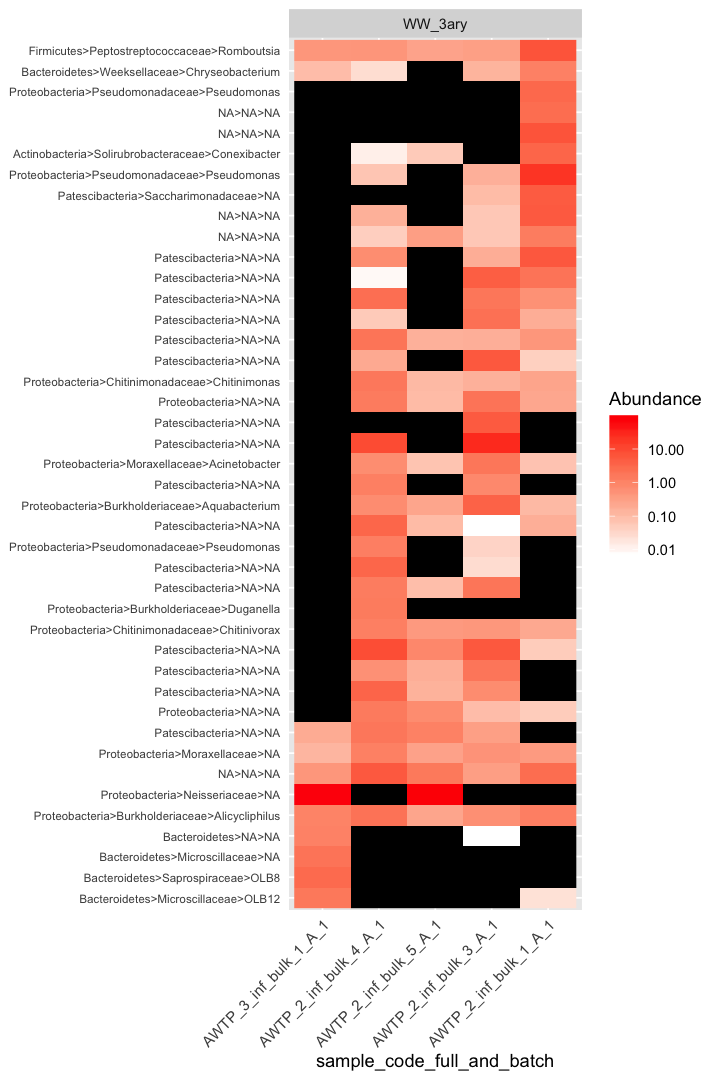

In [21]:
#plot heatmap
options(repr.plot.width = 6, repr.plot.height = 9)
plot_heatmap(ps_ww3ary_filt1.1, taxa.label = "combined", sample.label = "sample_code_full_and_batch", sample.order = "location_code", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")

# Beta diversity

In [22]:
#remove RO biofilm samples and AWTP3 samples

ps_dpwf_perc_bulk <- subset_samples(ps_dpwf_perc, subset = sample_type %in% "DEUF")
ps_dpwf_perc_bulk <- subset_samples(ps_dpwf_perc_bulk, subset = project_type %in% "DPWF")

ps_dpwf_bulk <- subset_samples(ps_dpwf, subset = sample_type %in% "DEUF")
ps_dpwf_bulk <- subset_samples(ps_dpwf_bulk, subset = project_type %in% "DPWF")

In [23]:
ps_dpwf_perc.ord <- ordinate(ps_dpwf_perc_bulk, "NMDS", "bray")

Square root transformation
Wisconsin double standardization
Run 0 stress 0.06352468 
Run 1 stress 0.06352468 
... New best solution
... Procrustes: rmse 5.589252e-06  max resid 1.416374e-05 
... Similar to previous best
Run 2 stress 0.06352468 
... Procrustes: rmse 1.647499e-06  max resid 3.980901e-06 
... Similar to previous best
Run 3 stress 0.06352468 
... Procrustes: rmse 6.203175e-06  max resid 1.430707e-05 
... Similar to previous best
Run 4 stress 0.06352468 
... Procrustes: rmse 1.800286e-06  max resid 3.615112e-06 
... Similar to previous best
Run 5 stress 0.06352468 
... New best solution
... Procrustes: rmse 2.221027e-06  max resid 6.114168e-06 
... Similar to previous best
Run 6 stress 0.06352468 
... Procrustes: rmse 1.592373e-06  max resid 4.039976e-06 
... Similar to previous best
Run 7 stress 0.06352468 
... Procrustes: rmse 2.145427e-06  max resid 5.056935e-06 
... Similar to previous best
Run 8 stress 0.06352468 
... New best solution
... Procrustes: rmse 1.594252e-06

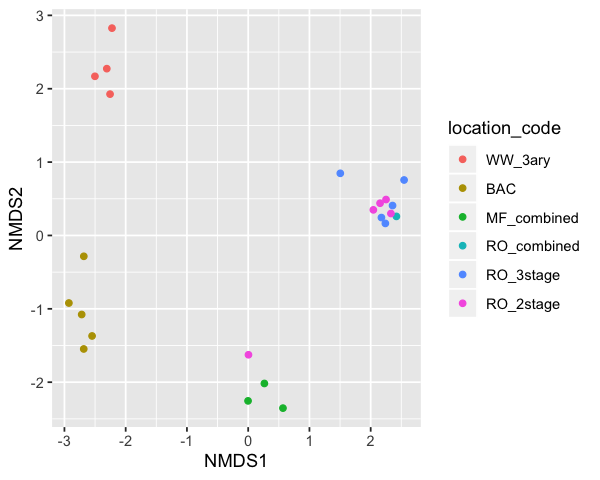

In [24]:
options(repr.plot.width = 5, repr.plot.height = 4)
plot_ordination(ps_dpwf_perc_bulk, ps_dpwf_perc.ord, type="samples", color="location_code") 

## Repeat ordination excluding outlier sample from bad extraction
(sample came from an extraction test: AWTP_2_RO2_bulk_4_B_Test_June2_W12)

In [25]:
ps_dpwf_perc_bulk <- subset_samples(ps_dpwf_perc_bulk, subset = !(sample_code_full_and_batch %in% "AWTP_2_RO2_bulk_4_B_Test_June2_W12"))

In [26]:
ps_dpwf_perc.ord <- ordinate(ps_dpwf_perc_bulk, "NMDS", "bray")

Square root transformation
Wisconsin double standardization
Run 0 stress 0.05571851 
Run 1 stress 0.05571851 
... New best solution
... Procrustes: rmse 2.195376e-05  max resid 5.719179e-05 
... Similar to previous best
Run 2 stress 0.05571852 
... Procrustes: rmse 3.889454e-05  max resid 0.0001298367 
... Similar to previous best
Run 3 stress 0.0557185 
... New best solution
... Procrustes: rmse 1.067078e-05  max resid 2.885319e-05 
... Similar to previous best
Run 4 stress 0.05571851 
... Procrustes: rmse 5.055417e-06  max resid 1.466664e-05 
... Similar to previous best
Run 5 stress 0.0557185 
... Procrustes: rmse 1.14171e-06  max resid 2.786257e-06 
... Similar to previous best
Run 6 stress 0.0557185 
... Procrustes: rmse 3.413586e-06  max resid 8.729998e-06 
... Similar to previous best
Run 7 stress 0.158096 
Run 8 stress 0.0557185 
... New best solution
... Procrustes: rmse 1.992325e-06  max resid 4.74245e-06 
... Similar to previous best
Run 9 stress 0.0557185 
... Procrustes: r

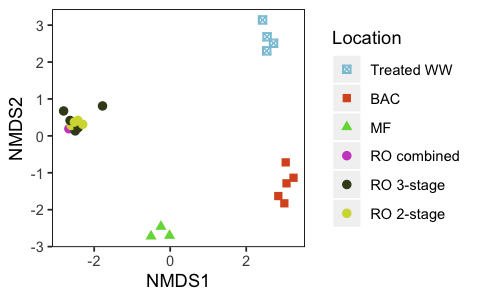

In [27]:
options(repr.plot.width = 4, repr.plot.height = 2.5)

plot_ordination(ps_dpwf_perc_bulk, ps_dpwf_perc.ord, color="location_code", shape="location_code") + 
    geom_point(size=2)+
    scale_shape_manual(values=c(7,15,17,19,19,19),
                       name="Location",
                       labels=c("Treated WW", "BAC", "MF", "RO combined", "RO 3-stage", "RO 2-stage"))+
    scale_color_manual(values = c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10]),
                       name="Location",
                       labels=c("Treated WW", "BAC", "MF", "RO combined", "RO 3-stage", "RO 2-stage"))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
ggsave('~/scientific_work/Nelson_lab/sandiego/dpwf_NMDS.pdf', device='pdf', width = 4, height = 2.5)

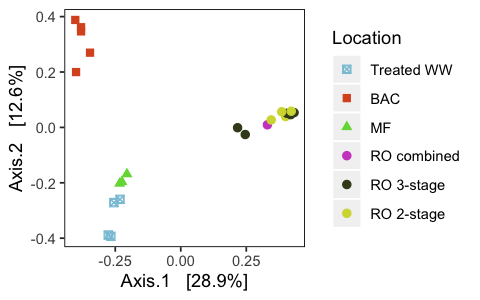

In [28]:
ps_dpwf_perc.pcoa <- ordinate(ps_dpwf_perc_bulk, "PCoA", "bray")

options(repr.plot.width = 4, repr.plot.height = 2.5)

plot_ordination(ps_dpwf_perc_bulk, ps_dpwf_perc.pcoa, color="location_code", shape="location_code") + 
    geom_point(size=2)+
    scale_shape_manual(values=c(7,15,17,19,19,19),
                       name="Location",
                       labels=c("Treated WW", "BAC", "MF", "RO combined", "RO 3-stage", "RO 2-stage"))+
    scale_color_manual(values = c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10]),
                       name="Location",
                       labels=c("Treated WW", "BAC", "MF", "RO combined", "RO 3-stage", "RO 2-stage"))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
ggsave('~/scientific_work/Nelson_lab/sandiego/dpwf_PCoA.pdf', device='pdf', width = 4, height = 2.5)

In [29]:
#based on DIY public restrooms tutorial: http://joey711.github.io/phyloseq-demo/Restroom-Biogeography.html

#Normalized by percent
sample_info = as((sample_data(ps_dpwf_perc_bulk)), "data.frame")
bulk_bray_perc = phyloseq::distance(ps_dpwf_perc_bulk, "bray")
bulk_adonis = adonis(bulk_bray_perc ~ location_gen + sample_date , sample_info)
bulk_adonis


Call:
adonis(formula = bulk_bray_perc ~ location_gen + sample_date,      data = sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

             Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
location_gen  3    4.3404 1.44680  6.1888 0.50239  0.001 ***
sample_date   5    1.2601 0.25201  1.0780 0.14585  0.308    
Residuals    13    3.0391 0.23378         0.35177           
Total        21    8.6396                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Rarefied data

In [30]:
#rarefied
sample_info = as((sample_data(ps_dpwf_bulk)), "data.frame")
ps_dpwf_bulk_rare <- rarefy_even_depth(ps_dpwf_bulk)
bray_rare = phyloseq::distance(ps_dpwf_bulk_rare, "bray")
adonis_rare = adonis(bray_rare ~ location_gen + sample_date, sample_info)
adonis_rare

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`

...
1016OTUs were removed because they are no longer 
present in any sample after random subsampling

...



Call:
adonis(formula = bray_rare ~ location_gen + sample_date, data = sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

             Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
location_gen  3    4.1107 1.37025  5.1674 0.44774  0.001 ***
sample_date   5    1.3579 0.27159  1.0242 0.14791  0.405    
Residuals    14    3.7124 0.26517         0.40435           
Total        22    9.1811                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Aitchison distance normalized data

In [31]:
##CLR-transformed Euclidean distance (Aitchison distance) 
##Suggested in Gloor et al 2017: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695134/
ps_bulk_clr <- microbiome::transform(ps_dpwf_bulk, transform='clr')
sample_info = as(sample_data(ps_bulk_clr), "data.frame")
bulk_eucl = phyloseq::distance(ps_bulk_clr, "euclidean")
bulk_adonis_clr = adonis(bulk_eucl ~ location_gen + sample_date, sample_info)
bulk_adonis_clr


Call:
adonis(formula = bulk_eucl ~ location_gen + sample_date, data = sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

             Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
location_gen  3     32492 10830.8  5.4213 0.46231  0.001 ***
sample_date   5      9820  1964.1  0.9831 0.13973  0.508    
Residuals    14     27969  1997.8         0.39796           
Total        22     70282                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Check for heterogeneity of beta-dispersions

In [32]:
beta <- betadisper(bulk_eucl, sample_info$location_code)
permutest(beta, permutations = 10000)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 10000

Response: Distances
          Df Sum Sq Mean Sq      F N.Perm Pr(>F)  
Groups     5   4337  867.39 6.4759  10000 0.0294 *
Residuals 17   2277  133.94                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

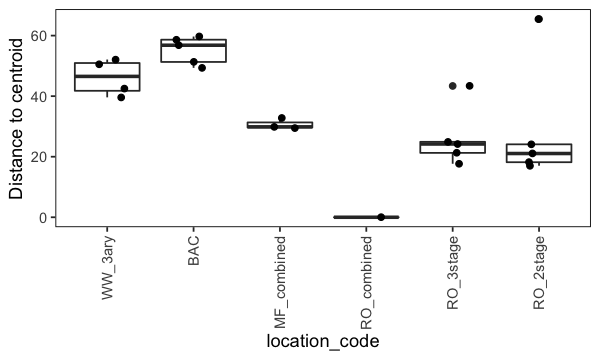

In [33]:
betadisper_distances <- as.data.frame(beta$distances)
colnames(betadisper_distances) <- c('distance_to_centroid')
betadisper_distances <- merge(betadisper_distances, sample_info, by = 0)

options(repr.plot.width = 5, repr.plot.height = 3) #for plotting size in jupyter
ggplot(betadisper_distances, aes(x=location_code, y=distance_to_centroid))+
    geom_boxplot()+
    geom_jitter(position=position_jitter(0.2))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA), axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5))+
    ylab('Distance to centroid')

#ggsave("~/data/awtp2_16S/beta_dispersion.pdf", device="pdf", width=5, height=3)

# Potential opportunistic pathogens

## Need to link TCC/ICC data before this can be calculated

# Shared ASVs across treatment processes

In [36]:
#function to identify core community within a location 
get_core_seqs <- function(ps_name, min_abund, min_samples, location){
    location_ids = as.character(get_variable(ps_name, "location_gen")) == location
    ps_sub <- prune_samples(location_ids, ps_name) #subsample by location
    
    #where number of samples=min_samples, for counts input min_reads-1 (because KOverA uses > not >=)
    core <- filter_taxa(ps_sub, filterfun(kOverA(min_samples, min_abund)), prune=TRUE) 
    return(row.names(tax_table(core))) #core sequences
}

In [38]:
ps_dpwf_perc_bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4212 taxa and 22 samples ]
sample_data() Sample Data:       [ 22 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4212 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 4212 reference sequences ]

In [39]:
min_abund <- 0.05 #percent #50 reads
min_samples <- 2
dataset <- ps_dpwf_perc_bulk

core.WW3 <- get_core_seqs(dataset, min_abund, min_samples, "WW_3ary") 
core.BAC <- get_core_seqs(dataset, min_abund, min_samples, "BAC")
core.MF <- get_core_seqs(dataset, min_abund, min_samples, "MF") 
core.RO <- get_core_seqs(dataset, min_abund, min_samples, "RO")

In [42]:
options(repr.plot.width = 2, repr.plot.height = 2)
pdf("~/data/awtp2_16S/venn_diagram_0.05perc_2sampmin.pdf", width=2, height=2)
cores=list(
    "RO"=core.RO,
    "BAC"=core.BAC,
    "MF"=core.MF,
    "WW3"=core.WW3
    )
grid.draw(venn.diagram(cores, NULL, col=c("gray", "#89C5DA", "#5F7FC7", "#DA5724" ), 
                       fill=c("white", "#89C5DA", "#5F7FC7", "#DA5724")))
dev.off()

pdf 
  2

In [ ]:
#plot intersect
partitions <- get.venn.partitions(cores)
allover_seqs <- partitions[partitions$BAC==TRUE & partitions$WW3==TRUE,]$..values..
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$RO==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$MF==TRUE & partitions$WW3==TRUE,]$..values..)


allover_seqs <- unname(c(unlist(allover_seqs))) #convert to unnamed vector
ps_allover <- prune_taxa(allover_seqs, dataset)

options(repr.plot.width = 6, repr.plot.height = 4)
plot_bar(ps_allover, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 6.5, repr.plot.height = 5)
plot_heatmap(ps_allover, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "sample_code_full_and_batch", #method=NULL,
             low="white", high="red", na.value="black", trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

Warning message:
“Transformation introduced infinite values in discrete y-axis”

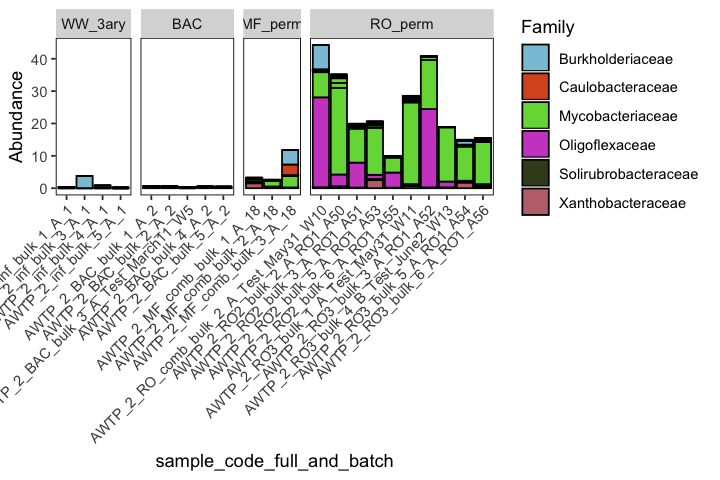

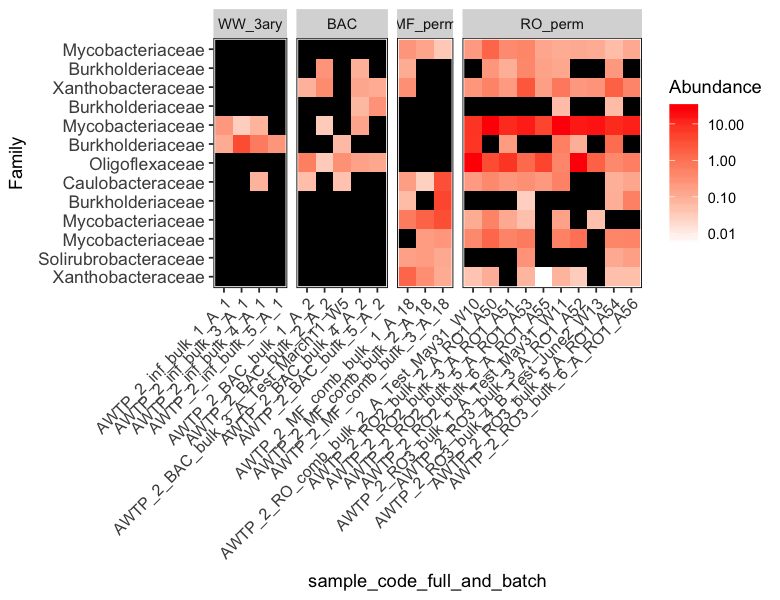

In [78]:
#plot RO shared core taxa
partitions <- get.venn.partitions(cores)
RO_seqs <- partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..
RO_seqs <- append(RO_seqs, partitions[partitions$RO==TRUE & partitions$BAC==TRUE,]$..values..)
RO_seqs <- append(RO_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)

RO_seqs <- unname(c(unlist(RO_seqs))) #convert to unnamed vector
ps_RO_cross <- prune_taxa(RO_seqs, dataset)

options(repr.plot.width = 6, repr.plot.height = 4)
plot_bar(ps_RO_cross, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 6.5, repr.plot.height = 5)
plot_heatmap(ps_RO_cross, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "sample_code_full_and_batch", #method=NULL,
             low="white", high="red", na.value="black", trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

In [25]:
ps_RO_cross <- prune_taxa(RO_seqs, ps)

options(repr.plot.width = 6, repr.plot.height = 4)
plot_bar(ps_RO_cross, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 6.5, repr.plot.height = 5)
plot_heatmap(ps_RO_cross, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "sample_code_full_and_batch", #method=NULL,
             low="white", high="red", na.value="black", trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

ERROR: Error in prune_taxa(RO_seqs, ps): object 'RO_seqs' not found


In [79]:
#what are these seqs and how abundant are they? Get otu table, tax table, merge, rename

shared_otus <- as.data.frame(otu_table(ps_RO_cross)) #get otu table
shared_otus <- as.data.frame(t(shared_otus)) #otus as rows
shared_taxa <- as.data.frame(tax_table(ps_RO_cross) [, c("Family","Genus")]) #get tax table
shared_seq_info <- merge(shared_otus, shared_taxa, by=0) #merge otus and tax tables

shared_seq_info$taxonomy <- paste(shared_seq_info$Family, shared_seq_info$Genus, sep="_") #convert tax to family_genus
row.names(shared_seq_info) <- shared_seq_info$taxonomy #make tax as rownames
shared_seq_info <- subset(shared_seq_info, select=c(-Row.names, -Family, -Genus, -taxonomy)) #drop extra columns

shared_seq_info <- t((shared_seq_info)) #transpose so taxa are columns, samples are rows
shared_seq_info <- as.data.frame(shared_seq_info)
names <- subset(sample_data(ps_RO_cross), select=c(Name, filtered_readcounts)) #get sample names for rows
shared_seq_info <- merge(names, shared_seq_info, by=0)
row.names(shared_seq_info) <- shared_seq_info$Name
shared_seq_info <- subset(shared_seq_info, select=c(-Name, -Row.names))
shared_seq_info <- shared_seq_info[order(row.names(shared_seq_info)),] #sort by sample name

shared_seq_info


Warning message:
“non-unique value when setting 'row.names': ‘Mycobacteriaceae_Mycobacterium’”

ERROR: Error in `.rowNamesDF<-`(x, value = value): duplicate 'row.names' are not allowed


# RO Biofilm samples
Remove A69 because it had 0.07 ng/ul, probably not good data